In [1]:
import torch
import torchvision
import torch.nn as nn
from PIL import Image
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.utils import to_categorical

In [64]:
train_path='/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
test_img_flair=nib.load(train_path+'BraTS20_Training_350/BraTS20_Training_350_flair.nii').get_fdata()
test_img_t1=nib.load(train_path+'BraTS20_Training_350/BraTS20_Training_350_t1.nii').get_fdata()
test_img_t1ce=nib.load(train_path+'BraTS20_Training_350/BraTS20_Training_350_t1ce.nii').get_fdata()
test_img_t2=nib.load(train_path+'BraTS20_Training_350/BraTS20_Training_350_t2.nii').get_fdata()
test_mask=nib.load(train_path+'BraTS20_Training_350/BraTS20_Training_350_seg.nii').get_fdata()
print(test_img_flair.max())
print(test_img_flair.shape)
print(test_mask.shape)
print(np.unique(test_mask.astype(np.uint8)))

2348.0
(240, 240, 155)
(240, 240, 155)
[0 1 2 4]


## Visualising a sample from the data

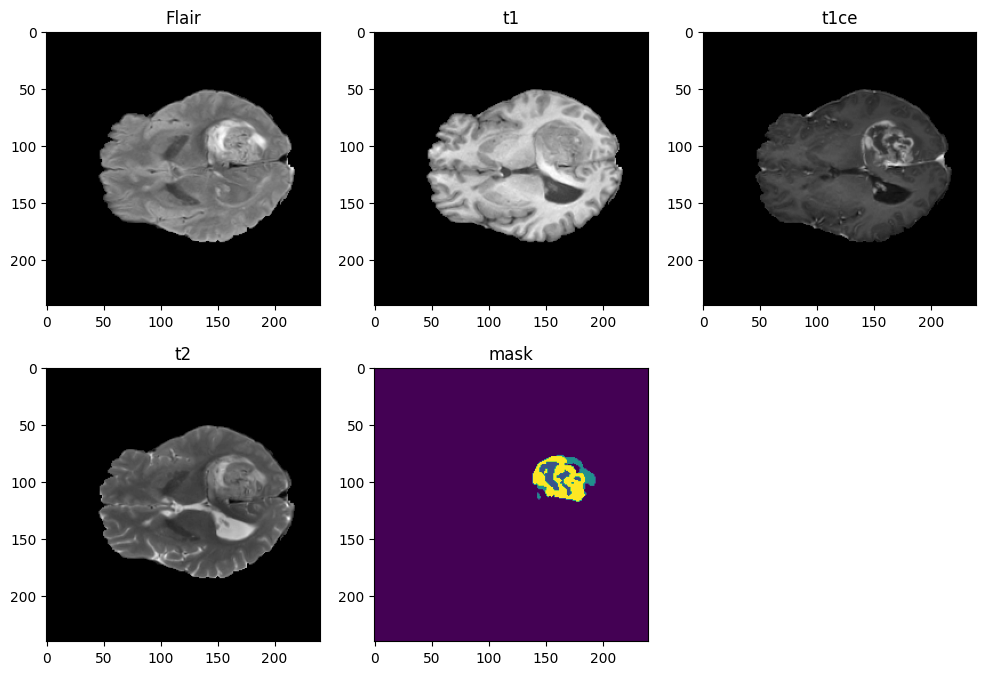

In [ ]:

import random
n_slice=random.randint(0,test_mask.shape[2]-1)
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(test_img_flair[:,:,n_slice],cmap='gray')
plt.title("Flair")
plt.subplot(232)
plt.imshow(test_img_t1[:,:,n_slice],cmap='gray')
plt.title("t1")
plt.subplot(233)
plt.imshow(test_img_t1ce[:,:,n_slice],cmap='gray')
plt.title("t1ce")
plt.subplot(234)
plt.imshow(test_img_t2[:,:,n_slice],cmap='gray')
plt.title("t2")
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title("mask")
plt.show()

In [69]:
test_mask[test_mask==4]=3
test_mask_onehot=torch.nn.functional.one_hot(torch.tensor(test_mask,dtype=torch.long),num_classes=4)

In [7]:
test_mask_onehot.shape

torch.Size([240, 240, 155, 4])

## Data Pre-Processing

In [ ]:
#Preprocessing the images
import glob
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

exclude_dir = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/'
t2_list=sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list=sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list=sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list=sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

t2_list = [file for file in t2_list if not file.startswith(exclude_dir)]
t1ce_list = [file for file in t1ce_list if not file.startswith(exclude_dir)]
flair_list = [file for file in flair_list if not file.startswith(exclude_dir)]
mask_list = [file for file in mask_list if not file.startswith(exclude_dir)]

t2_list = sorted(t2_list)
t1ce_list = sorted(t1ce_list)
flair_list = sorted(flair_list)
mask_list = sorted(mask_list)

image_dir = '/kaggle/working/images/'
mask_dir = '/kaggle/working/masks/'

os.makedirs(image_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

for img in range(len(t2_list)):
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1,temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
    
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1,temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
    
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1,temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
    
    temp_image_mask=nib.load(mask_list[img]).get_fdata()
    temp_image_mask=temp_image_mask.astype(np.uint8)
    temp_image_mask[temp_image_mask==4]=3
    
    temp_combined_images=np.stack([temp_image_t2,temp_image_t1ce,temp_image_flair],axis=3)

    temp_combined_images=temp_combined_images[56:184,56:184,13:141]
    temp_image_mask=temp_image_mask[56:184,56:184,13:141]
    
    val,counts= np.unique(temp_image_mask,return_counts=True)
    if (1-counts[0]/counts.sum()) > 0.01:
        temp_mask=to_categorical(temp_image_mask,num_classes=4)
        temp_mask=np.transpose(temp_mask,(3,2,0,1))
        temp_combined_images=np.transpose(temp_combined_images,(3,2,0,1))
        np.save('/kaggle/working/images/image'+str(img)+'.npy',temp_combined_images)
        np.save('/kaggle/working/masks/mask'+str(img)+'.npy',temp_mask)




In [3]:
from torch.utils.data import Dataset
class BrainDataset(Dataset):
    def __init__(self,img_dir,mask_dir,transforms):
        super(BrainDataset,self).__init__()
        self.img_dir=img_dir
        self.mask_dir=mask_dir
        self.transforms=transforms
        self.images=os.listdir(img_dir)
        self.masks=os.listdir(mask_dir)
        self.images.sort()
        self.masks.sort()
        

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        img_path=os.path.join(self.img_dir,self.images[idx])
        mask_path=os.path.join(self.mask_dir,self.masks[idx])
        img=np.load(img_path)
        mask=np.load(mask_path)
        img=torch.tensor(img)
        mask=torch.tensor(mask,dtype=torch.long)
        
        if self.transforms is not None:
            img=self.transforms(img)
            mask=self.transforms(mask)

        return img,mask
        
        

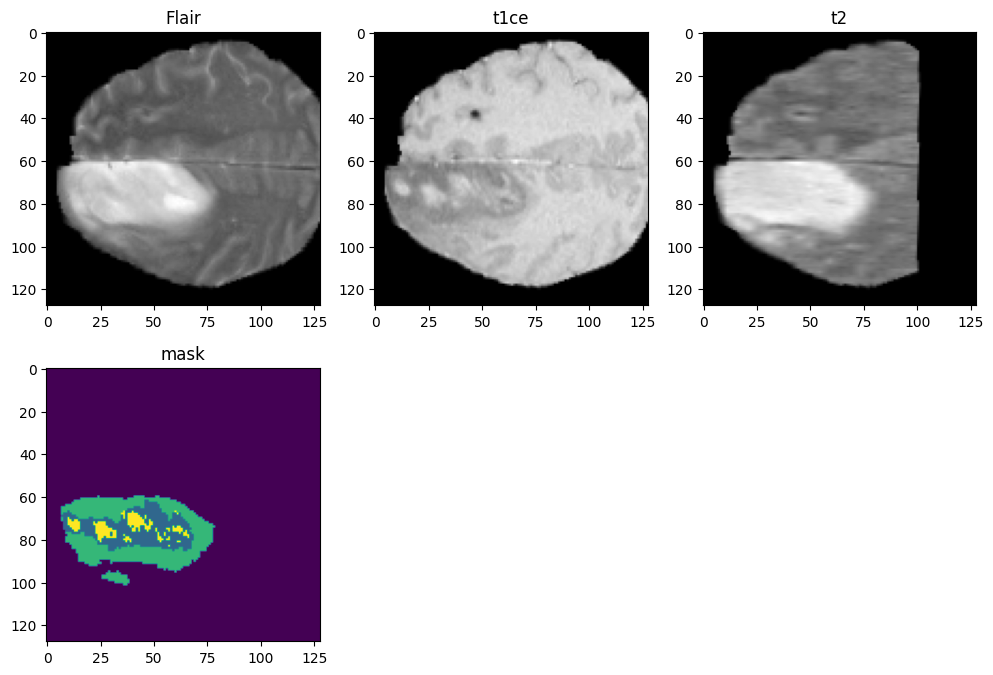

In [59]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
image_dir = '/kaggle/input/bratsdata/images'
mask_dir = '/kaggle/input/bratsdata/masks'

transform=None

dataset = BrainDataset(image_dir, mask_dir,transform)
dataloader=DataLoader(dataset,batch_size=2,shuffle=True)
for img,msk in dataloader:
 test_img=img[0]
 test_mask=msk[0]
 single_channel_mask = torch.argmax(test_mask, dim=0)
 import random
 n_slice=random.randint(0,test_mask.shape[1]-1)
 plt.figure(figsize=(12,8))
 plt.subplot(231)
 plt.imshow(test_img[0,n_slice,:,:],cmap='gray')
 plt.title("Flair")
 plt.subplot(232)
 plt.imshow(test_img[1,n_slice,:,:],cmap='gray')
 plt.title("t1ce")
 plt.subplot(233)
 plt.imshow(test_img[2,n_slice,:,:],cmap='gray')
 plt.title("t2")
 plt.subplot(234)
 plt.imshow(single_channel_mask[n_slice,:,:])
 plt.title("mask")
 plt.show()
 break

In [5]:
print(msk.shape)

torch.Size([2, 4, 128, 128, 128])


In [6]:
print(img.shape)

torch.Size([2, 3, 128, 128, 128])


In [7]:
from torch.utils.data import random_split
train_size=int(0.8*len(dataset))
val_size=int(0.1*len(dataset))
test_size= len(dataset)-train_size-val_size

train_data,val_data,test_data=random_split(dataset,[train_size,val_size,test_size])
print(train_size)
print(test_size)

275
35


In [8]:
from torch.utils.data.dataloader import DataLoader
batch_size=1
train_dl=DataLoader(train_data,batch_size,shuffle=True,num_workers=0,pin_memory=True)
val_dl=DataLoader(val_data,batch_size*2,shuffle=True,num_workers=0,pin_memory=True)

In [9]:
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else: return torch.device('cpu')

def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [10]:
class DoubleConv(nn.Module):
    def __init__(self,in_chan,out_chan):
        super(DoubleConv,self).__init__()
        self.double_conv=nn.Sequential(
            nn.Conv3d(in_chan,out_chan,kernel_size=3,padding=1),
            nn.BatchNorm3d(out_chan),
            nn.ReLU(),
            nn.Dropout3d(0.2),
            nn.Conv3d(out_chan,out_chan,kernel_size=3,padding=1),
            nn.BatchNorm3d(out_chan),
            nn.ReLU()
            )
    def forward(self,x):
            return self.double_conv(x)

## Defining the model-architechture

In [11]:
class UNet(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(UNet, self).__init__()
        
        # Downsampling path
        self.down1 = DoubleConv(in_chan, 16)
        self.down2 = DoubleConv(16, 32)
        self.down3 = DoubleConv(32, 64)
        self.down4 = DoubleConv(64, 128)
        self.down5 = DoubleConv(128, 256)
        
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        
        # Upsampling path
        self.up4 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(256, 128)
        self.up3 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 64)
        self.up2 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(64, 32)
        self.up1 = nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(32, 16)
        
        self.out_conv = nn.Conv3d(16, out_chan, kernel_size=1)

    def forward(self, x):
        # Downsampling
        d1 = self.down1(x)
        d1_pooled = self.pool(d1)
        d2 = self.down2(d1_pooled)
        d2_pooled = self.pool(d2)
        d3 = self.down3(d2_pooled)
        d3_pooled = self.pool(d3)
        d4 = self.down4(d3_pooled)
        d4_pooled = self.pool(d4)
        d5 = self.down5(d4_pooled)
        
        # Upsampling
        u4 = self.up4(d5)
        u4 = torch.cat((u4, d4), dim=1)
        u4 = self.conv4(u4)
        
        u3 = self.up3(u4)
        u3 = torch.cat((u3, d3), dim=1)
        u3 = self.conv3(u3)
        
        u2 = self.up2(u3)
        u2 = torch.cat((u2, d2), dim=1)
        u2 = self.conv2(u2)
        
        u1 = self.up1(u2)
        u1 = torch.cat((u1, d1), dim=1)
        u1 = self.conv1(u1)
        
        return self.out_conv(u1)


In [12]:
def dice_coefficient(pred, target, num_classes):
    dice = torch.zeros(num_classes, device=pred.device)
    for i in range(num_classes):
        pred_i = (pred == i).float()
        target_i = (target == i).float()
        intersection = (pred_i * target_i).sum()
        union = pred_i.sum() + target_i.sum()
        dice[i] = 2. * intersection / (union + 1e-6)  
    return dice.mean()

def intersection_over_union(pred, target, num_classes):
    iou = torch.zeros(num_classes, device=pred.device)
    for i in range(num_classes):
        pred_i = (pred == i).float()
        target_i = (target == i).float()
        intersection = (pred_i * target_i).sum()
        union = (pred_i + target_i).sum() - intersection
        iou[i] = intersection / (union + 1e-6)  
    return iou.mean()


## Define the train and evaluation function

In [60]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    loss=[]
    val_iou=[]
    val_dice=[]
    for batch in val_loader:
        img , mask = batch
        img=img.float()
        out=model(img)
        if mask.shape[1] > 1:
            mask = torch.argmax(mask, dim=1)
        loss1 = nn.CrossEntropyLoss()
        loss.append(loss1(out,mask))
        pred=torch.argmax(out, dim=1)
        val_dice.append(dice_coefficient(pred, mask, 4))
        val_iou.append(intersection_over_union(pred,mask, 4))
    epoch_loss=torch.stack(loss).mean()
    epoch_dice=torch.stack(val_dice).mean()
    epoch_iou=torch.stack(val_iou).mean()
    return {'val_loss':epoch_loss.item(),'val_dice':epoch_dice.item(),'val_iou':epoch_iou.item()}

def fit(epochs,model,lr,optim_func,train_loader,val_loader):
    model.train()
    optimizer=optim_func(model.parameters(),lr)
    history=[]
    for epoch in range(epochs):
        train_list=[]
        for batch_idx,(images,masks) in enumerate(train_loader):
            images=images.float()
            out=model(images)
            if masks.shape[1] > 1:
                masks = torch.argmax(masks, dim=1)
            loss1=nn.CrossEntropyLoss()
            loss=loss1(out,masks)
            train_list.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss=torch.stack(train_list).mean()
        result=evaluate(model,val_loader)
        result['train_loss']=train_loss.item()
        history.append(result)
        print(f"Epoch:{epoch},train_loss:{result['train_loss']},val_loss:{result['val_loss']},val_iou:{result['val_iou']},val_dice:{result['val_dice']}")
    return history


In [13]:
device=get_device()

In [14]:
print(device)

cuda


In [15]:
model=UNet(3,4)

In [16]:
model=to_device(UNet(3,4),device)

In [28]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

In [29]:
import torch.optim as optim
num_epochs=50
lr=0.0001
opt_func=optim.Adam


In [30]:
print(len(val_dl))  


17


## Training the model

In [31]:
history=fit(epochs=num_epochs,model=model,lr=lr,optim_func=opt_func,train_loader=train_dl,val_loader=val_dl)

Epoch:0,train_loss:1.1250684261322021,val_loss:0.9858404994010925,val_iou:0.3133133053779602,val_dice:0.36681774258613586
Epoch:1,train_loss:0.19905170798301697,val_loss:0.13285867869853973,val_iou:0.308366596698761,val_dice:0.3512062728404999
Epoch:2,train_loss:0.15262995660305023,val_loss:0.14175184071063995,val_iou:0.2855163514614105,val_dice:0.3176386058330536
Epoch:3,train_loss:0.14343541860580444,val_loss:0.11946427077054977,val_iou:0.3156798481941223,val_dice:0.3602648675441742
Epoch:4,train_loss:0.12888549268245697,val_loss:0.10427624732255936,val_iou:0.37117213010787964,val_dice:0.43860650062561035
Epoch:5,train_loss:0.12208141386508942,val_loss:0.11413518339395523,val_iou:0.3614698350429535,val_dice:0.41496410965919495
Epoch:6,train_loss:0.11386720091104507,val_loss:0.09391970932483673,val_iou:0.3579464256763458,val_dice:0.4117864668369293
Epoch:7,train_loss:0.10895588248968124,val_loss:0.10233248025178909,val_iou:0.3667312264442444,val_dice:0.4238379895687103
Epoch:8,train_l

In [22]:
test_loader=DataLoader(test_data,batch_size=2,shuffle=False)
test_loader=DeviceDataLoader(test_loader,device)

## Visualising Predictions

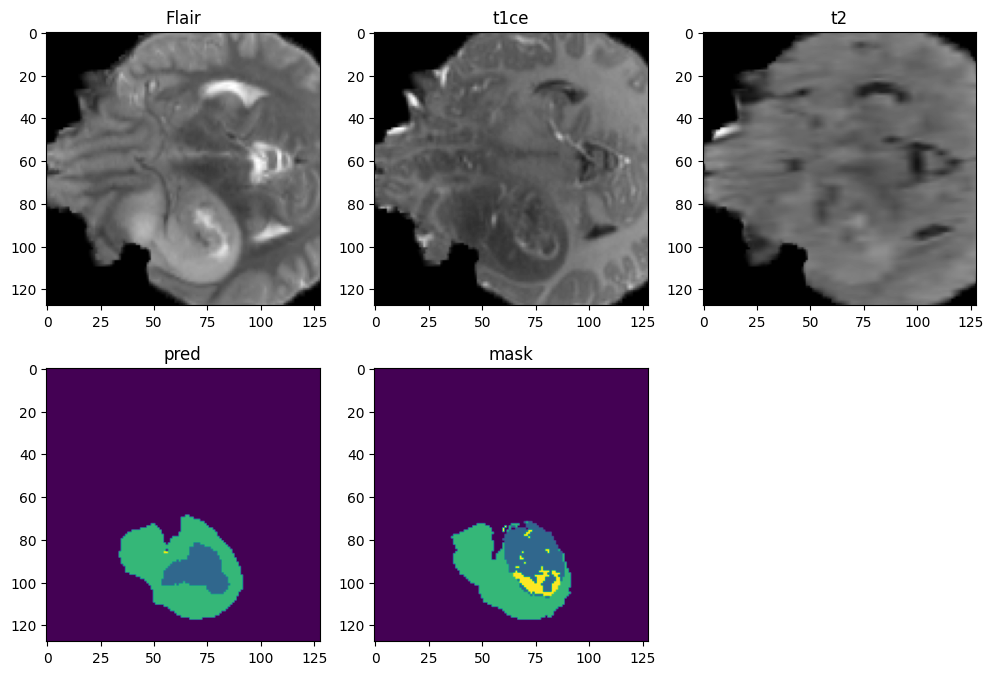

In [57]:
#Visualising predictions from the model
for img,msk in test_loader:
 test_img=img[0]
 test_mask=msk[0]
 single_channel_mask = torch.argmax(test_mask, dim=0)
 img=img.float()
 out=model(img)
 pred=torch.argmax(out, dim=1)
 import random
 n_slice=random.randint(0,test_mask.shape[1]-1)
 plt.figure(figsize=(12,8))
 plt.subplot(231)
 plt.imshow(test_img[0,n_slice,:,:].cpu().numpy(),cmap='gray')
 plt.title("Flair")
 plt.subplot(232)
 plt.imshow(test_img[1,n_slice,:,:].cpu().numpy(),cmap='gray')
 plt.title("t1ce")
 plt.subplot(233)
 plt.imshow(test_img[2,n_slice,:,:].cpu().numpy(),cmap='gray')
 plt.title("t2")
 plt.subplot(234)
 plt.imshow(pred[0,n_slice,:,:].cpu().numpy())
 plt.title("pred")
 plt.subplot(235)
 plt.imshow(single_channel_mask[n_slice,:,:].cpu().numpy())
 plt.title("mask")
 plt.show()
 break

In [63]:
test_result=evaluate(model,test_loader)
print(f"test loss: {test_result['val_loss']:.4f}")
print(f"Dice Coefficient: {test_result['val_dice']:.4f}")
print(f"IoU: {test_result['val_iou']:.4f}")

test loss: 0.0326
Dice Coefficient: 0.8018
IoU: 0.7013
